In [1]:
#imports for the project
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from datetime import timedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from tabulate import tabulate

# **Wind Farm #1**

In [2]:
# Setting the path to the dataset folder
DATA_PATH = 'Datasets'

# Reading the Excel file containing data for Wind farm site 1 into a DataFrame
df_wf1 = pd.read_excel(
    os.path.join(DATA_PATH,'Wind farm site 1 (Nominal capacity-99MW).xlsx'), 
)

# Setting display option to show all columns when displaying the DataFrame
pd.set_option('display.max_columns', None)
df_wf1

,Time(year-month-day h:m:s),Wind speed at height of 10 meters (m/s),Wind direction at height of 10 meters (˚),Wind speed at height of 30 meters (m/s),Wind direction at height of 30 meters (˚),Wind speed at height of 50 meters (m/s),Wind direction at height of 50 meters (˚),Wind speed - at the height of wheel hub (m/s),Wind speed - at the height of wheel hub (˚),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [3]:
# Renaming the columns of the DataFrame df_wf1 for clarity and consistency
df_wf1.columns=['time','WS_10','WD_10','WS_30','WD_30','WS_50','WD_50','WS_cen','WD_cen','Air_T','Air_P','Air_H','Power(MW)']

# Stripping any leading or trailing whitespace from the column names of df_wf1
df_wf1.columns = [col.strip() for col in df_wf1.columns]

In [4]:
df_wf1.describe()

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,5.711011,222.829748,6.039255,220.633957,6.168763,221.868203,6.375876,216.986224,8.543324,889.527469,37.581143,23.426896
std,3.119512,73.705902,3.700131,79.846922,3.874708,83.092270,3.907965,85.404564,13.368410,2.439019,18.896256,24.130181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-24.131000,858.400000,1.502000,0.000000
25%,3.538000,209.431500,3.302000,192.871000,3.194000,169.800000,3.300000,144.067000,-3.271000,889.550000,22.355000,1.572839
50%,5.389000,235.987000,5.783000,245.442000,5.811000,251.833000,5.879500,248.825000,9.823000,889.742000,34.401500,14.957783
75%,7.217250,275.287000,8.091000,277.580250,8.384000,281.433000,8.604000,279.304250,19.756000,889.925000,51.584000,40.215230
max,25.465000,358.987000,29.187000,359.087000,29.678000,358.933000,30.247000,358.500000,36.130000,918.192000,93.120000,98.094440


In [5]:
# Filtering rows in DataFrame df_wf1 where the 'Power(MW)' column has a value of 0.0
df_wf1[df_wf1['Power(MW)'] == 0.0]

# Shows only around 200 / 70000 rows have zero power, mostly real values in the data

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
39247,2020-02-13 19:45:00,3.378,125.700,4.118,111.548,4.456,114.367,4.631,110.267,-1.859,889.567,24.475,0.0
39248,2020-02-13 20:00:00,3.343,128.193,4.602,109.619,4.861,111.433,5.040,105.733,-2.201,890.200,25.381,0.0
39249,2020-02-13 20:15:00,3.448,142.987,4.513,115.724,4.681,116.833,4.736,110.300,-2.814,890.283,25.963,0.0
39250,2020-02-13 20:30:00,3.503,147.780,4.755,117.541,4.727,119.900,4.728,114.000,-2.753,889.583,25.968,0.0
39251,2020-02-13 20:45:00,3.656,139.320,4.862,111.267,5.121,112.900,5.258,108.533,-3.267,890.100,26.437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,2020-08-22 21:15:00,6.288,266.327,7.827,264.050,8.048,268.900,8.369,266.983,22.202,889.400,23.480,0.0
57590,2020-08-22 21:30:00,6.451,260.760,7.705,262.396,8.150,267.700,8.494,264.900,21.460,889.717,24.067,0.0
57591,2020-08-22 21:45:00,5.180,258.653,6.334,259.231,6.924,265.633,7.119,260.400,21.502,889.567,24.744,0.0
57592,2020-08-22 22:00:00,5.211,241.840,6.157,245.209,6.550,253.367,6.766,248.783,21.014,889.550,25.536,0.0


In [6]:
# Displaying information about the DataFrame df_wf1, including the data types, number of non-null values, and memory usage
df_wf1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       70176 non-null  object 
 1   WS_10      70176 non-null  float64
 2   WD_10      70176 non-null  float64
 3   WS_30      70176 non-null  float64
 4   WD_30      70176 non-null  float64
 5   WS_50      70176 non-null  float64
 6   WD_50      70176 non-null  float64
 7   WS_cen     70176 non-null  float64
 8   WD_cen     70176 non-null  float64
 9   Air_T      70176 non-null  float64
 10  Air_P      70176 non-null  float64
 11  Air_H      70176 non-null  float64
 12  Power(MW)  70176 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


In [7]:
# Converting the 'time' column in DataFrame df_wf1 to datetime format using the specified format string '%Y-%m-%d %H:%M:%S'
df_wf1['time'] = pd.to_datetime(df_wf1['time'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Checking is there is any null data in the dataframe
df_wf1.isnull().mean()

time         0.0
WS_10        0.0
WD_10        0.0
WS_30        0.0
WD_30        0.0
WS_50        0.0
WD_50        0.0
WS_cen       0.0
WD_cen       0.0
Air_T        0.0
Air_P        0.0
Air_H        0.0
Power(MW)    0.0
dtype: float64

In [9]:
# DataFrame df_wf1
df_wf1

,time,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
0,2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
1,2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2,2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
3,2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
4,2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70171,2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
70172,2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
70173,2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931
70174,2020-12-31 23:30:00,3.730,242.580,3.280,252.492,3.204,268.600,3.446,266.733,-9.633,889.492,54.677,7.185250


In [10]:
# Setting the 'time' column as the index of DataFrame df_wf1, making it the new index for the DataFrame
df_wf1.set_index('time', inplace=True)
df_wf1

,WS_10,WD_10,WS_30,WD_30,WS_50,WD_50,WS_cen,WD_cen,Air_T,Air_P,Air_H,Power(MW)
time,,,,,,,,,,,,
2019-01-01 00:00:00,2.209,81.317,1.991,74.814,2.094,77.667,2.494,74.500,-13.484,889.867,76.320,0.254383
2019-01-01 00:15:00,1.828,77.460,1.698,75.048,1.757,88.733,1.882,74.367,-13.691,889.575,76.757,0.329703
2019-01-01 00:30:00,2.193,86.700,2.313,84.688,2.344,89.100,2.350,89.000,-13.766,889.942,76.981,0.296306
2019-01-01 00:45:00,2.654,78.160,2.494,74.939,2.574,87.267,2.808,82.733,-13.691,889.675,76.821,0.187590
2019-01-01 01:00:00,2.249,94.297,2.192,91.140,2.558,96.900,2.924,92.967,-13.447,890.025,74.571,0.081005
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,5.738,234.600,6.408,235.454,6.575,242.033,6.680,238.433,-9.108,890.008,53.312,13.633642
2020-12-31 23:00:00,5.748,229.333,6.231,233.423,6.372,239.800,6.448,236.833,-9.978,889.817,53.877,6.869759
2020-12-31 23:15:00,4.468,235.133,4.406,253.261,4.381,263.400,4.399,261.733,-9.808,889.825,54.437,4.352931


In [11]:
# Resampling DataFrame df_wf1 to a frequency of 15 minutes ('15min'), filling any missing values with NaN
df_wf1 = df_wf1.asfreq('15min')
print(df_wf1.index.freq)

<15 * Minutes>


In [12]:
# Downsample DataFrame df_wf1 to a frequency of 30 minutes ('30min'), filling any missing values with NaN
df_wf1 = df_wf1.resample('1H').asfreq()

**STL decomposition**

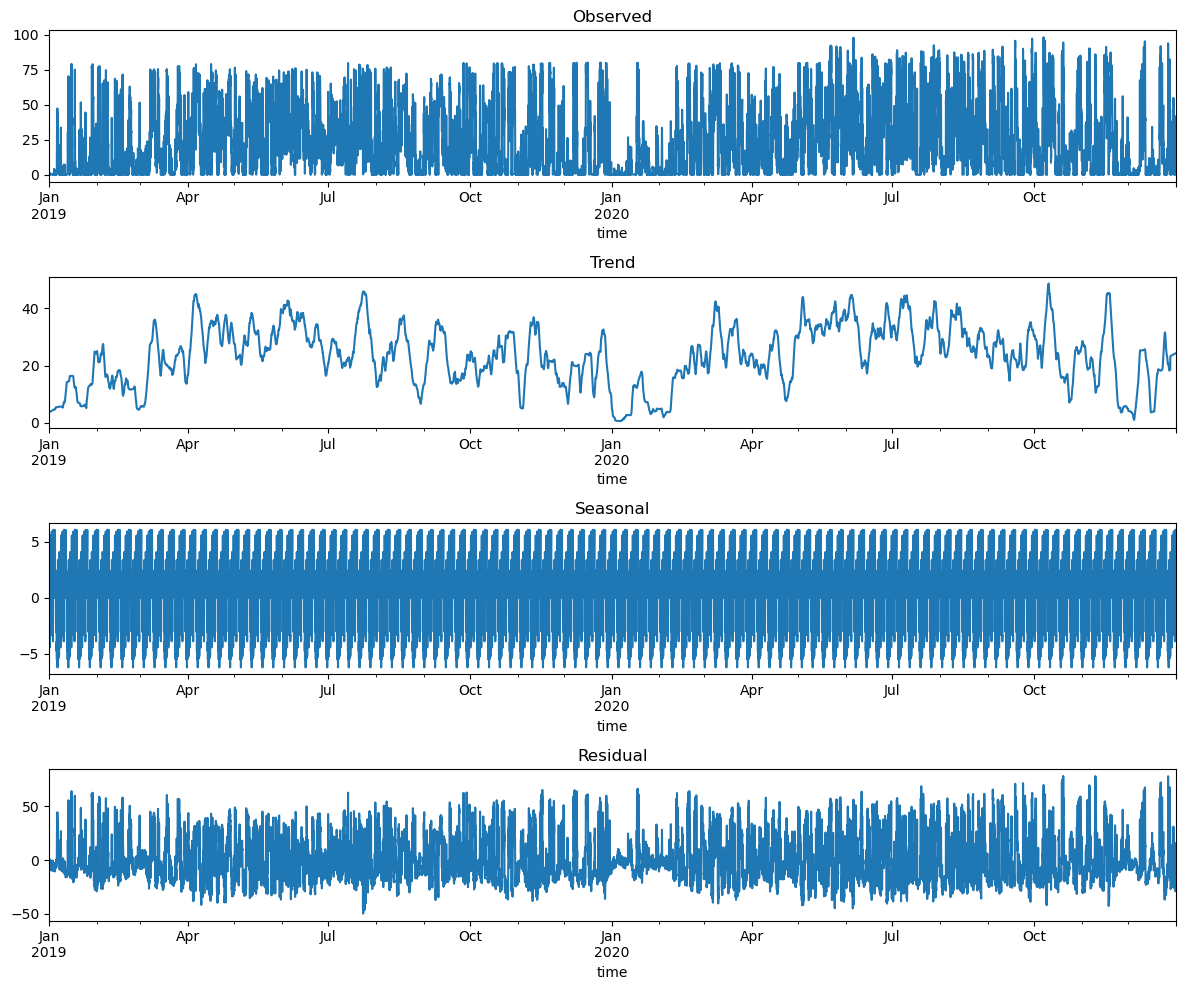

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

stl_result = seasonal_decompose(df_wf1['Power(MW)'], model='additive', extrapolate_trend='freq', period=(24*7))


stl_result.observed.plot(ax=axes[0], title='Observed')
stl_result.trend.plot(ax=axes[1], title='Trend')
stl_result.seasonal.plot(ax=axes[2], title='Seasonal')
stl_result.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()

plt.show()

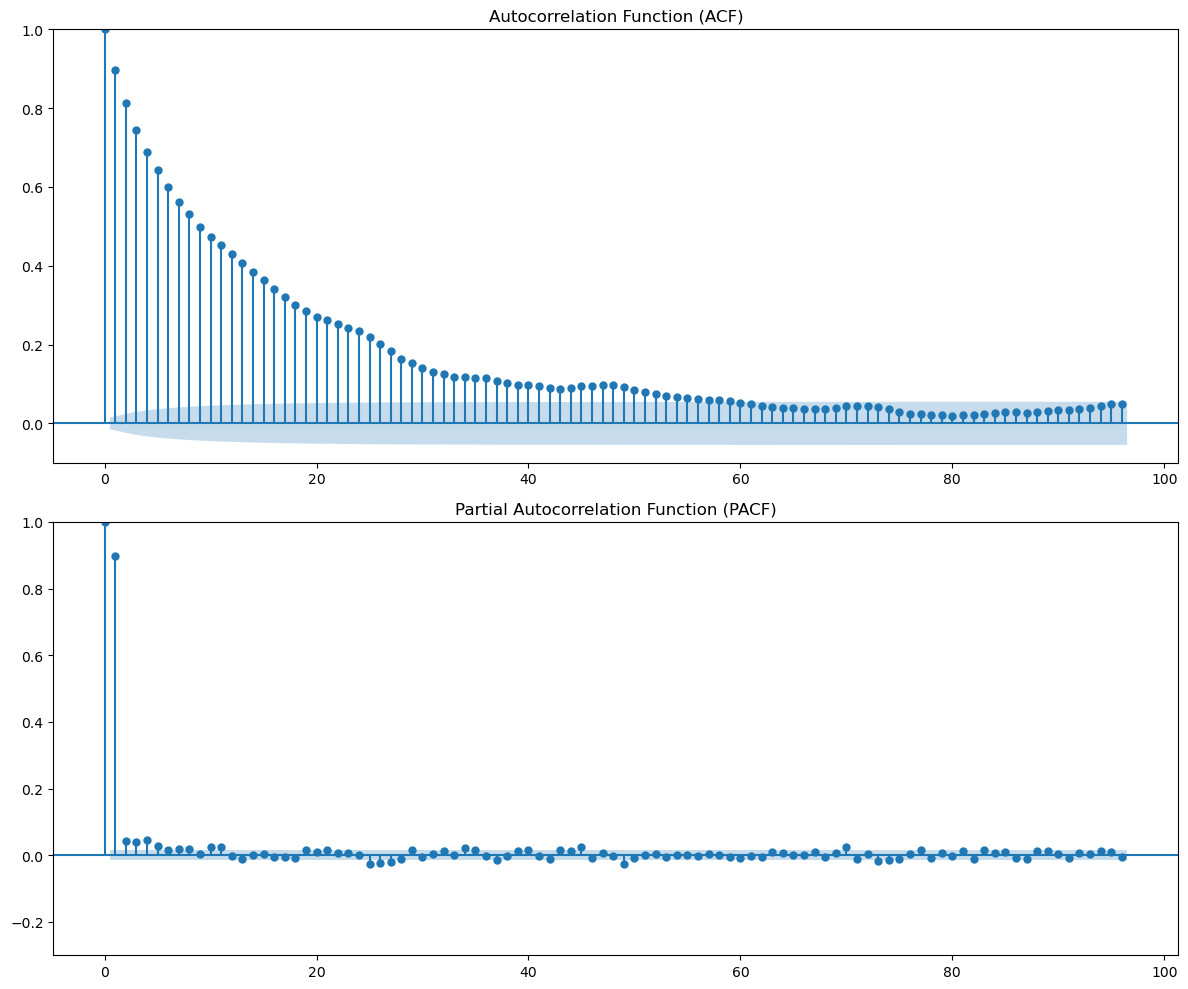

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot
plot_acf(df_wf1['Power(MW)'], lags=96, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_ylim(-0.1, 1)

# PACF plot
plot_pacf(df_wf1['Power(MW)'], lags=96, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_ylim(-0.3, 1)

plt.tight_layout()
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on df_wf1['Power(MW)']
result = adfuller(df_wf1['Power(MW)'])

# Extract and print the test statistic
test_statistic = result[0]
print("ADF Statistic:", test_statistic)

# Extract and print the p-value
p_value = result[1]
print("p-value:", p_value)

# Extract and print the critical values
critical_values = result[4]
print("Critical Values:")
for key, value in critical_values.items():
    print(f"\t{key}: {value}")

ADF Statistic: -14.026785987121723
p-value: 3.491808491680766e-26
Critical Values:
	1%: -3.430723750472268
	5%: -2.8617051832726124
	10%: -2.5668579227683557


**We pass the test, data is stationary.**

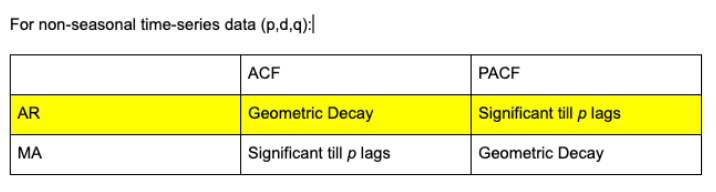

## **Preparing training, testing and demo datasets**

We will slip the entire .csv file into three subdatasets:

- **Modeling**
1. Training (to input training data into forecasting models)
2. Testing (to test forecasting models comparing forcasting with testing data)

- **Demo**
3. Historical (to refit the training+testing with real data after each user forecast request; 1 month of data)

In [16]:
one_month_range = df_wf1.index.max() - pd.DateOffset(months=1)

# Create a DataFrame df_demo containing data from the last month of data in the dataset
df_demo = df_wf1[df_wf1.index >= one_month_range]

# Create a DataFrame df_wf1_model containing data up to one month before the maximum timestamp
df_wf1_model = df_wf1[df_wf1.index < one_month_range]

# Split the training set into quarters
df_wf1_first_50, df_wf1_last_50 = train_test_split(df_wf1_model, train_size = 0.5, test_size = 0.5, shuffle=False)

df_wf1_first_25, df_wf1_second_25 = train_test_split(df_wf1_first_50, train_size = 0.5, test_size = 0.5, shuffle=False)
df_wf1_third_25, df_wf1_fourth_25 = train_test_split(df_wf1_last_50, train_size = 0.5, test_size = 0.5, shuffle=False)

# Split each quarter into training and testing sets, with a train size of 98% and a test size of 2%
df_wf1_1_train, df_wf1_1_test = train_test_split(df_wf1_first_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_2_train, df_wf1_2_test = train_test_split(df_wf1_second_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_3_train, df_wf1_3_test = train_test_split(df_wf1_third_25, train_size = 0.995, test_size = 0.005, shuffle=False)
df_wf1_4_train, df_wf1_4_test = train_test_split(df_wf1_fourth_25, train_size = 0.995, test_size = 0.005, shuffle=False)

In [17]:
features_to_test=['WS_cen', 'WD_cen', 'Air_T']

# Creating training sets for each quarter of the dataset
y_train_1 = df_wf1_1_train[['Power(MW)']]
X_train_1 = df_wf1_1_train[features_to_test]

y_train_2 = df_wf1_2_train[['Power(MW)']]
X_train_2 = df_wf1_2_train[features_to_test]

y_train_3 = df_wf1_3_train[['Power(MW)']]
X_train_3 = df_wf1_3_train[features_to_test]

y_train_4 = df_wf1_4_train[['Power(MW)']]
X_train_4 = df_wf1_4_train[features_to_test]

y_train_1 = y_train_1.tail(6715)
y_train_2 = y_train_2.tail(6715)
y_train_3 = y_train_3.tail(6715)
y_train_4 = y_train_4.tail(6715)

# Creating a list of tuples containing each training set (target variable and features)
train_datasets = [(y_train_1, X_train_1), (y_train_2, X_train_2), (y_train_3, X_train_3), (y_train_4, X_train_4)]

In [18]:
y_train_1

,Power(MW)
time,
2019-01-01 00:00:00,0.254383
2019-01-01 01:00:00,0.081005
2019-01-01 02:00:00,0.184037
2019-01-01 03:00:00,1.082193
2019-01-01 04:00:00,0.226671
...,...
2019-06-23 21:00:00,65.655650
2019-06-23 22:00:00,43.869675
2019-06-23 23:00:00,40.427690


In [19]:
# Creating test sets for each quarter of the dataset
y_test_1 = df_wf1_1_test[['Power(MW)']]
X_test_1 = df_wf1_1_test[features_to_test]

y_test_2 = df_wf1_2_test[['Power(MW)']]
X_test_2 = df_wf1_2_test[features_to_test]

y_test_3 = df_wf1_3_test[['Power(MW)']]
X_test_3 = df_wf1_3_test[features_to_test]

y_test_4 = df_wf1_4_test[['Power(MW)']]
X_test_4 = df_wf1_4_test[features_to_test]

# Creating a list of tuples containing each test set (target variable and features)
test_datasets = [(y_test_1, X_test_1), (y_test_2, X_test_2), (y_test_3, X_test_3), (y_test_4, X_test_4)]

In [20]:
print(df_wf1.index.freq)

<Hour>


## **Naïve forecaster model**

In [21]:
start_time = time.time()

naive_predictions_dict = {}

for i, (y_train, _) in enumerate(train_datasets, 1):
    y_test, _ = test_datasets[i - 1]

    forecast_naive = NaiveForecaster(strategy="mean")
    forecasted_naive = forecast_naive.fit(y_train)

    forecast_horizon = ForecastingHorizon([i for i in range(1, len(y_test)+1)])

    predictions_naive = forecasted_naive.predict(fh=forecast_horizon)

    naive_predictions_dict[f'predictions_{i}'] = predictions_naive

y_pred_naive_1 = naive_predictions_dict['predictions_1']
y_pred_naive_2 = naive_predictions_dict['predictions_2']
y_pred_naive_3 = naive_predictions_dict['predictions_3']
y_pred_naive_4 = naive_predictions_dict['predictions_4']

end_time = time.time()
naiveTime = end_time - start_time

## **AR(1) model**

In [22]:
predictions_ar_1_dict = {}

start_time = time.time()

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test = test_datasets[i - 1][0]
    X_test = test_datasets[i - 1][1]
    
    y_pred_ar_1 = []

    # Adjust the order parameter for ARIMA model
    model_ar_1 = ARIMA(y_train, order=(1, 0, 0))
    model_fit_ar_1 = model_ar_1.fit()

    current_date = y_test.index[0]

    while current_date <= y_test.index[-1]:
        # Predict one step ahead
        prediction_ar_1 = model_fit_ar_1.forecast(steps=1).iloc[0]
        # Append the prediction to the list
        y_pred_ar_1.append(prediction_ar_1)
    
        # Create a DataFrame for prediction
        y_pred_ar_1_df = pd.DataFrame([prediction_ar_1], columns=y_train.columns, index=[current_date])
        
        # Update the model with the predicted value
        model_fit_ar_1 = model_fit_ar_1.append(y_pred_ar_1_df, refit=True)
    
        current_date += timedelta(minutes=60)

    # Store the predictions in a dictionary
    predictions_ar_1_dict[f'predictions_{i}'] = pd.Series(y_pred_ar_1, index=y_test.index)

# Assign the predictions to variables
y_pred_ar_1_1 = predictions_ar_1_dict['predictions_1']
y_pred_ar_1_2 = predictions_ar_1_dict['predictions_2']
y_pred_ar_1_3 = predictions_ar_1_dict['predictions_3']
y_pred_ar_1_4 = predictions_ar_1_dict['predictions_4']

end_time = time.time()
ar_1_Time = end_time - start_time

In [23]:
# import itertools

# p = q = range(0, 3)
# d = range(0, 2)
# pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# # Grid search
# min_aic = float('inf')
# best_params = None

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         try:
#             model = SARIMAX(y_train_1, order=param, seasonal_order=seasonal_param)
#             results = model.fit()
#             if results.aic < min_aic:
#                 min_aic = results.aic
#                 best_params = (param, seasonal_param)
#         except:
#             continue

# print('Best SARIMA parameters:', best_params)

c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hussa\anaconda3\envs\ml_hussa\lib\s

Best SARIMA parameters: ((2, 0, 2), (2, 1, 2, 12))


## **SARIMA model**

In [24]:
predictions_sarima_dict = {}
start_time = time.time()

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test = test_datasets[i - 1][0]
    X_test = test_datasets[i - 1][1]
    
    y_pred_sarima = []

    # Fit SARIMA model
    model_sarima = SARIMAX(y_train, order=(2, 0, 2), seasonal_order=(2, 1, 2, 24))
    model_fit_sarima = model_sarima.fit()

    current_date = y_test.index[0]

    while current_date <= y_test.index[-1]:
        # Predict one step ahead
        prediction_sarima = model_fit_sarima.forecast(steps=1).iloc[0]
        # Append the prediction to the list
        y_pred_sarima.append(prediction_sarima)
    
        # Create a DataFrame for prediction
        y_pred_sarima_df = pd.DataFrame([prediction_sarima], columns=y_train.columns, index=[current_date])
        
        # Update the model with the predicted value
        model_fit_sarima = model_fit_sarima.append(y_pred_sarima_df, refit=True)
    
        current_date += timedelta(minutes=60)

    # Store the predictions in a dictionary
    predictions_sarima_dict[f'predictions_{i}'] = pd.Series(y_pred_sarima, index=y_test.index)

# Assign the predictions to variables
y_pred_sarima_1 = predictions_sarima_dict['predictions_1']
y_pred_sarima_2 = predictions_sarima_dict['predictions_2']
y_pred_sarima_3 = predictions_sarima_dict['predictions_3']
y_pred_sarima_4 = predictions_sarima_dict['predictions_4']

end_time = time.time()
sarima_Time = end_time - start_time

c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\hussa\anaconda3\envs\ml_hussa\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **AR(2) model**

In [ ]:
predictions_ar_2_dict = {}

start_time = time.time()

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test = test_datasets[i - 1][0]
    X_test = test_datasets[i - 1][1]
    
    y_pred_ar_2 = []

    # Adjust the order parameter for ARIMA model
    model_ar_2 = ARIMA(y_train, order=(2, 0, 0))
    model_fit_ar_2 = model_ar_2.fit()

    current_date = y_test.index[0]

    while current_date <= y_test.index[-1]:
        # Predict one step ahead
        prediction_ar_2 = model_fit_ar_2.forecast(steps=1).iloc[0]
        # Append the prediction to the list
        y_pred_ar_2.append(prediction_ar_2)
    
        # Create a DataFrame for prediction
        y_pred_ar_2_df = pd.DataFrame([prediction_ar_2], columns=y_train.columns, index=[current_date])
        
        # Update the model with the predicted value
        model_fit_ar_2 = model_fit_ar_2.append(y_pred_ar_2_df, refit=True)
    
        current_date += timedelta(minutes=60)

    # Store the predictions in a dictionary
    predictions_ar_2_dict[f'predictions_{i}'] = pd.Series(y_pred_ar_2, index=y_test.index)

# Assign the predictions to variables
y_pred_ar_2_1 = predictions_ar_2_dict['predictions_1']
y_pred_ar_2_2 = predictions_ar_2_dict['predictions_2']
y_pred_ar_2_3 = predictions_ar_2_dict['predictions_3']
y_pred_ar_2_4 = predictions_ar_2_dict['predictions_4']

end_time = time.time()
ar_2_Time = end_time - start_time

c:\Users\delatour.m\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\delatour.m\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\delatour.m\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## **AR(3) model**

In [ ]:
predictions_ar_3_dict = {}

start_time = time.time()

for i, (y_train, X_train) in enumerate(train_datasets, 1):
    y_test = test_datasets[i - 1][0]
    X_test = test_datasets[i - 1][1]
    
    y_pred_ar_3 = []

    # Adjust the order parameter for ARIMA model
    model_ar_3 = ARIMA(y_train, order=(3, 0, 0))
    model_fit_ar_3 = model_ar_3.fit()

    current_date = y_test.index[0]

    while current_date <= y_test.index[-1]:
        # Predict one step ahead
        prediction_ar_3 = model_fit_ar_3.forecast(steps=1).iloc[0]
        # Append the prediction to the list
        y_pred_ar_3.append(prediction_ar_3)
    
        # Create a DataFrame for prediction
        y_pred_ar_3_df = pd.DataFrame([prediction_ar_3], columns=y_train.columns, index=[current_date])
        
        # Update the model with the predicted value
        model_fit_ar_3 = model_fit_ar_3.append(y_pred_ar_3_df, refit=True)
    
        current_date += timedelta(minutes=60)

    # Store the predictions in a dictionary
    predictions_ar_3_dict[f'predictions_{i}'] = pd.Series(y_pred_ar_3, index=y_test.index)

# Assign the predictions to variables
y_pred_ar_3_1 = predictions_ar_3_dict['predictions_1']
y_pred_ar_3_2 = predictions_ar_3_dict['predictions_2']
y_pred_ar_3_3 = predictions_ar_3_dict['predictions_3']
y_pred_ar_3_4 = predictions_ar_3_dict['predictions_4']

end_time = time.time()
ar_3_Time = end_time - start_time

## **Summary**

In [ ]:
"""
mae_naive_1 = mean_absolute_error(y_test_1, y_pred_naive_1)
mae_naive_2 = mean_absolute_error(y_test_2, y_pred_naive_2)
mae_naive_3 = mean_absolute_error(y_test_3, y_pred_naive_3)
mae_naive_4 = mean_absolute_error(y_test_4, y_pred_naive_4)
average_mae_naive = (mae_naive_1 + mae_naive_2 + mae_naive_3 + mae_naive_4) / 4
"""

mae_ar_1_1 = mean_absolute_error(y_test_1, y_pred_ar_1_1)
mae_ar_1_2 = mean_absolute_error(y_test_2, y_pred_ar_1_2)
mae_ar_1_3 = mean_absolute_error(y_test_3, y_pred_ar_1_3)
mae_ar_1_4 = mean_absolute_error(y_test_4, y_pred_ar_1_4)
average_mae_ar_1 = (mae_ar_1_1 + mae_ar_1_2 + mae_ar_1_3 + mae_ar_1_4) / 4

mae_sarima_1 = mean_absolute_error(y_test_1, y_pred_sarima_1)
mae_sarima_2 = mean_absolute_error(y_test_2, y_pred_sarima_2)
mae_sarima_3 = mean_absolute_error(y_test_3, y_pred_sarima_3)
mae_sarima_4 = mean_absolute_error(y_test_4, y_pred_sarima_4)
average_mae_sarima = (mae_sarima_1 + mae_sarima_2 + mae_sarima_3 + mae_sarima_4) / 4

mae_ar_2_1 = mean_absolute_error(y_test_1, y_pred_ar_2_1)
mae_ar_2_2 = mean_absolute_error(y_test_2, y_pred_ar_2_2)
mae_ar_2_3 = mean_absolute_error(y_test_3, y_pred_ar_2_3)
mae_ar_2_4 = mean_absolute_error(y_test_4, y_pred_ar_2_4)
average_mae_ar_2 = (mae_ar_2_1 + mae_ar_2_2 + mae_ar_2_3 + mae_ar_2_4) / 4

mae_ar_3_1 = mean_absolute_error(y_test_1, y_pred_ar_3_1)
mae_ar_3_2 = mean_absolute_error(y_test_2, y_pred_ar_3_2)
mae_ar_3_3 = mean_absolute_error(y_test_3, y_pred_ar_3_3)
mae_ar_3_4 = mean_absolute_error(y_test_4, y_pred_ar_3_4)
average_mae_ar_3 = (mae_ar_3_1 + mae_ar_3_2 + mae_ar_3_3 + mae_ar_3_4) / 4

In [ ]:
models = [
    #"Naive Forecaster",
    "AR(1)", 
    #"Random Forest (n_estimators=100, random_state=42)", 
    #"XGBoost (max_depth=3, learning_rate=0.11, n_estimators=62)",
    #"Reduction + KNN",
    #"Reduction + XGBoost (window_length=5)",
    "SARIMA(1,0,0)(1,0,0,24*7)",
    "AR(2)",
    "AR(3)"
]

maes = [
    #[mae_naive_1, mae_naive_2, mae_naive_3, mae_naive_4, average_mae_naive],
    [mae_ar_1_1, mae_ar_1_2, mae_ar_1_3, mae_ar_1_4, average_mae_ar_1],
    #[mae_randomforest_1, mae_randomforest_2, mae_randomforest_3, mae_randomforest_4, average_mae_randomforest],
    #[mae_xgboost_1, mae_xgboost_2, mae_xgboost_3, mae_xgboost_4, average_mae_xgboost],
    #[mae_reduction_knn_1, mae_reduction_knn_2, mae_reduction_knn_3, mae_reduction_knn_4, average_mae_reduction_knn],
    #[mae_reduction_xgboost_1, mae_reduction_xgboost_2, mae_reduction_xgboost_3, mae_reduction_xgboost_4, average_mae_reduction_xgboost],
    [mae_sarima_1, mae_sarima_2, mae_sarima_3, mae_sarima_4, average_mae_sarima],
    [mae_ar_2_1, mae_ar_2_2, mae_ar_2_3, mae_ar_2_4, average_mae_ar_2],
    [mae_ar_3_1, mae_ar_3_2, mae_ar_3_3, mae_ar_3_4, average_mae_ar_3]
]

run_times = [
    #[naiveTime],
    [ar_1_Time],
    #[randomforestTime],
    #[xgboostTime],
    #[reduction_knn_Time],
    #[xgboostreductionTime],
    [sarima_Time],
    [ar_2_Time],
    [ar_3_Time]
]

headers = ["Model", "MAE 1", "MAE 2", "MAE 3", "MAE 4", "Average MAE", "RunTimes"]
table_data = []

for model, mae_list, times in zip(models, maes, run_times):
    table_data.append([model] + mae_list + times)

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------------------------+---------+---------+---------+----------+---------------+------------+
| Model                     |   MAE 1 |   MAE 2 |   MAE 3 |    MAE 4 |   Average MAE |   RunTimes |
+===========================+=========+=========+=========+==========+===============+============+
| AR(1)                     | 30.2934 | 21.4497 | 11.5344 | 10.96    |       18.5594 |    10.679  |
+---------------------------+---------+---------+---------+----------+---------------+------------+
| SARIMA(1,0,0)(1,0,0,24*7) | 23.8214 | 18.3789 | 11.9865 |  8.97205 |       15.7897 |  1946.7    |
+---------------------------+---------+---------+---------+----------+---------------+------------+
| AR(2)                     | 27.3319 | 16.765  | 12.4779 | 10.2027  |       16.6944 |    43.2187 |
+---------------------------+---------+---------+---------+----------+---------------+------------+
| AR(3)                     | 26.8752 | 16.9439 | 12.4885 |  9.14429 |       16.363  |    43.9146 |


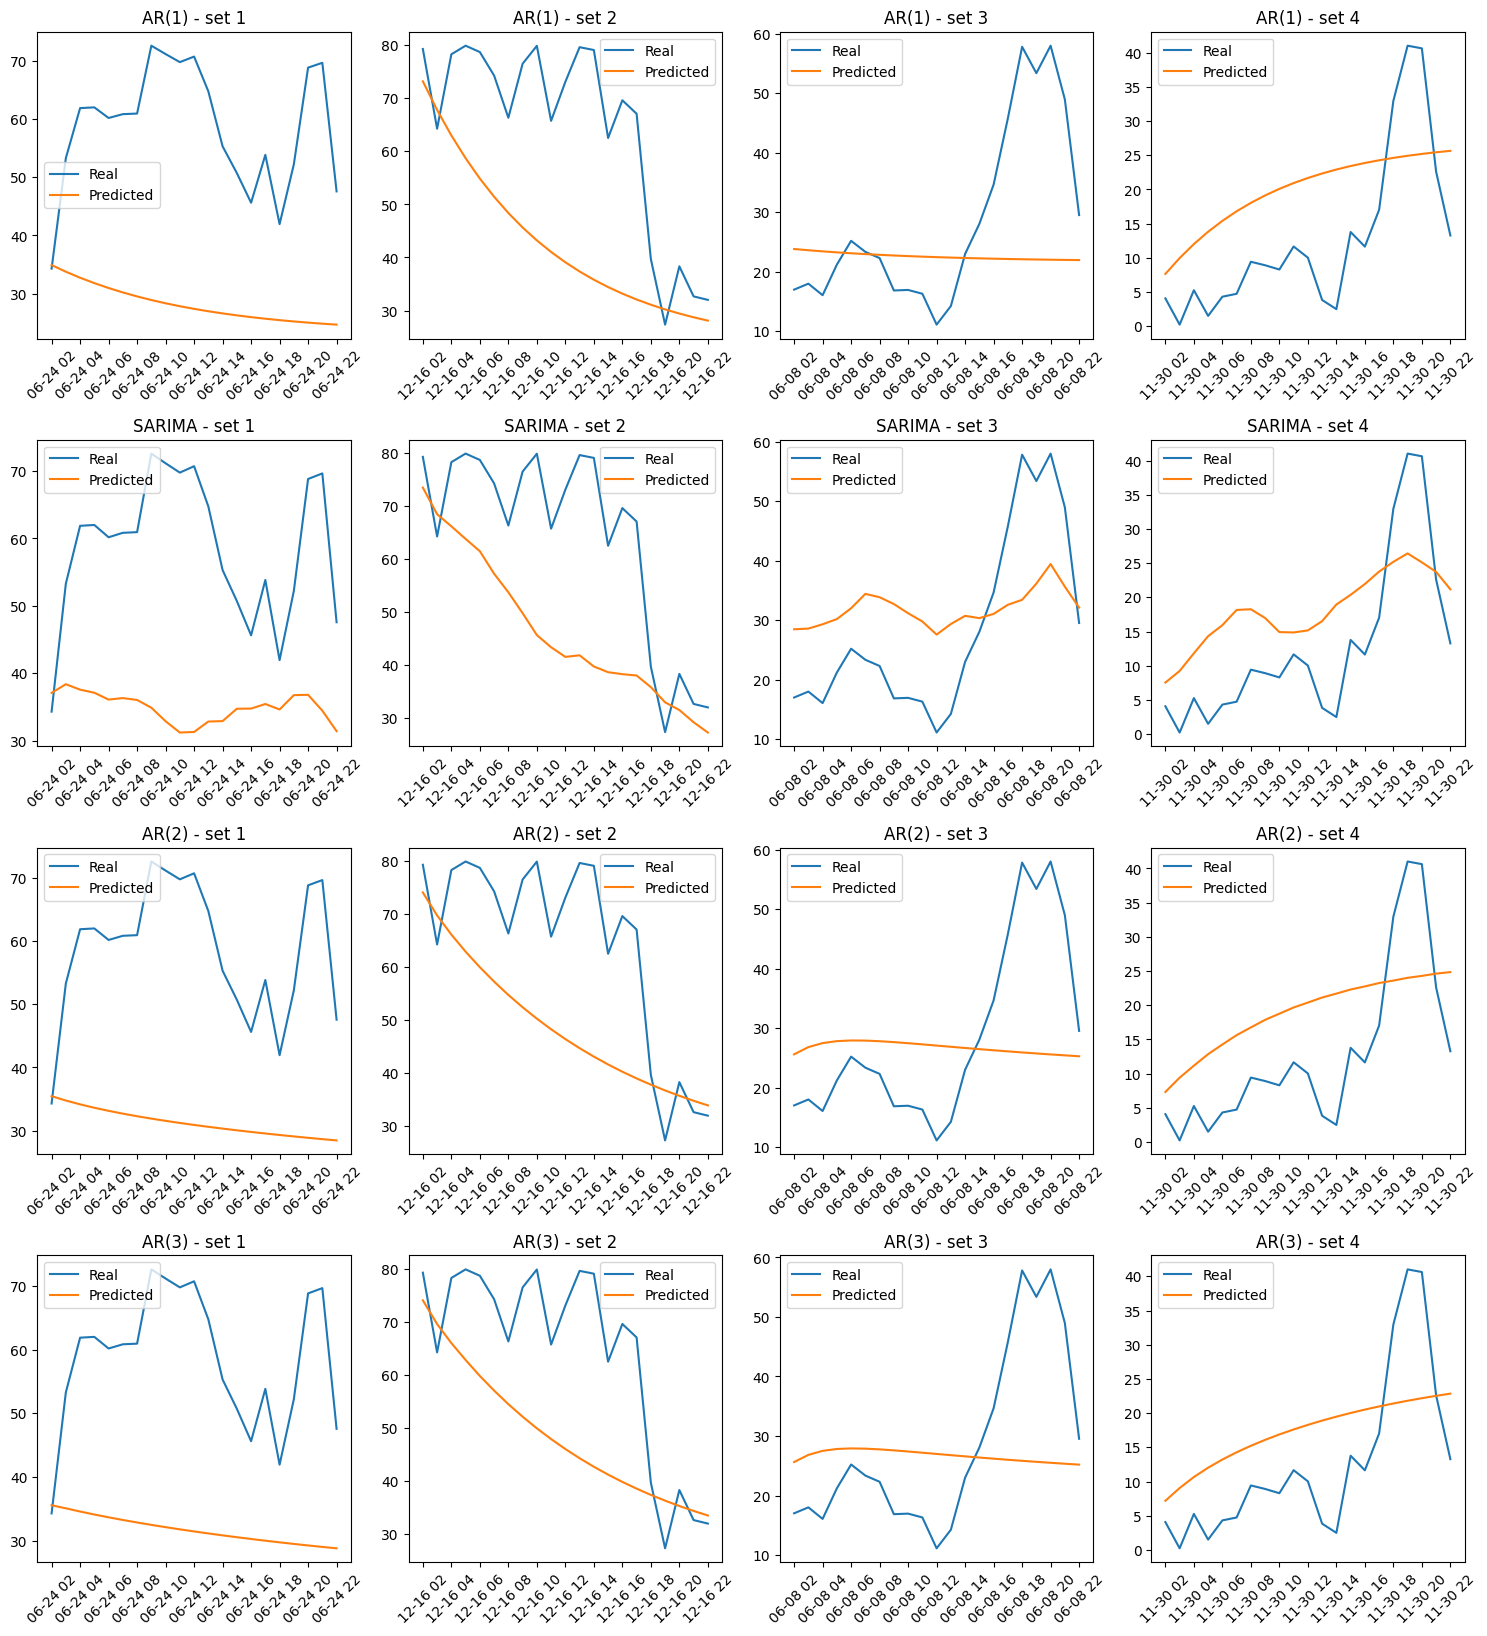

In [ ]:
plt.figure(figsize=(15, 36))  # Increase the height to accommodate one more row

"""
# Plot Naive Forecaster
plt.subplot(9, 4, 1)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_naive_1, label='Predicted')
plt.title('Naive Forecaster - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 2)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_naive_2, label='Predicted')
plt.title('Naive Forecaster - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 3)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_naive_3, label='Predicted')
plt.title('Naive Forecaster - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 4)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_naive_4, label='Predicted')
plt.title('Naive Forecaster - set 4')
plt.legend()
plt.xticks(rotation=45)
"""

# Plot AR(1)
plt.subplot(9, 4, 5)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_ar_1_1, label='Predicted')
plt.title('AR(1) - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 6)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_ar_1_2, label='Predicted')
plt.title('AR(1) - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 7)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_ar_1_3, label='Predicted')
plt.title('AR(1) - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 8)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_ar_1_4, label='Predicted')
plt.title('AR(1) - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot ARMA(1,1)
plt.subplot(9, 4, 9)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_sarima_1, label='Predicted')
plt.title('SARIMA - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 10)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_sarima_2, label='Predicted')
plt.title('SARIMA - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 11)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_sarima_3, label='Predicted')
plt.title('SARIMA - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 12)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_sarima_4, label='Predicted')
plt.title('SARIMA - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot AR(2)
plt.subplot(9, 4, 13)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_ar_2_1, label='Predicted')
plt.title('AR(2) - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 14)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_ar_2_2, label='Predicted')
plt.title('AR(2) - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 15)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_ar_2_3, label='Predicted')
plt.title('AR(2) - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 16)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_ar_2_4, label='Predicted')
plt.title('AR(2) - set 4')
plt.legend()
plt.xticks(rotation=45)

# Plot AR(3)
plt.subplot(9, 4, 17)
plt.plot(y_test_1, label='Real')
plt.plot(y_pred_ar_3_1, label='Predicted')
plt.title('AR(3) - set 1')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 18)
plt.plot(y_test_2, label='Real')
plt.plot(y_pred_ar_3_2, label='Predicted')
plt.title('AR(3) - set 2')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 19)
plt.plot(y_test_3, label='Real')
plt.plot(y_pred_ar_3_3, label='Predicted')
plt.title('AR(3) - set 3')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(9, 4, 20)
plt.plot(y_test_4, label='Real')
plt.plot(y_pred_ar_3_4, label='Predicted')
plt.title('AR(3) - set 4')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()